In [5]:
import argparse
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from google.colab.patches import cv2_imshow
def find_hough_circles(image, edge_image, r_min, r_max, delta_r, num_thetas, bin_threshold, post_process = True):
  #image size
  img_height, img_width = edge_image.shape[:2]
  
  # R and Theta ranges
  dtheta = int(360 / num_thetas)
  
  ## Thetas is bins created from 0 to 360 degree with increment of the dtheta
  thetas = np.arange(0, 360, step=dtheta)
  
  ## Radius ranges from r_min to r_max 
  rs = np.arange(r_min, r_max, step=delta_r)
  
  # Calculate Cos(theta) and Sin(theta) it will be required later
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  
  # Evaluate and keep ready the candidate circles dx and dy for different delta radius
  # based on the the parametric equation of circle.
  # x = x_center + r * cos(t) and y = y_center + r * sin(t),  
  # where (x_center,y_center) is Center of candidate circle with radius r. t in range of [0,2PI)
  circle_candidates = []
  for r in rs:
    for t in range(num_thetas):
      #instead of using pre-calculated cos and sin theta values you can calculate here itself by following
      #circle_candidates.append((r, int(r*cos(2*pi*t/num_thetas)), int(r*sin(2*pi*t/num_thetas))))
      #but its better to pre-calculate and use it here.
      circle_candidates.append((r, int(r * cos_thetas[t]), int(r * sin_thetas[t])))
  
  # Hough Accumulator, we are using defaultdic instead of standard dict as this will initialize for key which is not 
  # aready present in the dictionary instead of throwing exception.
  accumulator = defaultdict(int)
  
  for y in range(img_height):
    for x in range(img_width):
      if edge_image[y][x] != 0: #white pixel
        # Found an edge pixel so now find and vote for circle from the candidate circles passing through this pixel.
        for r, rcos_t, rsin_t in circle_candidates:
          x_center = x - rcos_t
          y_center = y - rsin_t
          accumulator[(x_center, y_center, r)] += 1 #vote for current candidate
  
  # Output image with detected lines drawn
  output_img = image.copy()
  # Output list of detected circles. A single circle would be a tuple of (x,y,r,threshold) 
  out_circles = []
  
  # Sort the accumulator based on the votes for the candidate circles 
  for candidate_circle, votes in sorted(accumulator.items(), key=lambda i: -i[1]):
    x, y, r = candidate_circle
    current_vote_percentage = votes / num_thetas
    if current_vote_percentage >= bin_threshold: 
      # Shortlist the circle for final result
      out_circles.append((x, y, r, current_vote_percentage))
      print(x, y, r, current_vote_percentage)
      
  
  # Post process the results, can add more post processing later.
  if post_process :
    pixel_threshold = 5
    postprocess_circles = []
    for x, y, r, v in out_circles:
      # Exclude circles that are too close of each other
      # all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc, v in postprocess_circles)
      # Remove nearby duplicate circles based on pixel_threshold
      if all(abs(x - xc) > pixel_threshold or abs(y - yc) > pixel_threshold or abs(r - rc) > pixel_threshold for xc, yc, rc, v in postprocess_circles):
        postprocess_circles.append((x, y, r, v))
    out_circles = postprocess_circles
  
    
  # Draw shortlisted circles on the output image
  for x, y, r, v in out_circles:
    output_img = cv2.circle(output_img, (x,y), r, (0,255,0), 2)
  
  return output_img, out_circles

def plot_image(image,color,title):
  plt.grid("false")
  plt.title(title)
  if(color=='colored'):
    plt.imshow(image)
  elif(color=="gray"):
    plt.imshow(image,cmap='gray',interpolation="bicubic")

def BGR2RGB(image):
  return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)



def main():
    
    r_min = 20
    r_max = 200
    delta_r = 1
    num_thetas = 100
    bin_threshold = 0.4
    min_edge_threshold = 100
    max_edge_threshold = 200
    
    input_img = cv2.imread('/content/drive/MyDrive/standard.png')
    cv2_imshow(input_img)
    # image processing and noice reduction
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    cv2_imshow(gray)

    gaussian_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    cv2_imshow(gaussian_blur)

    canny = cv2.Canny(gaussian_blur,50,150) 
    cv2_imshow(canny)



    #Edge detection on the input image
    edge_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    #ret, edge_image = cv2.threshold(edge_image, 120, 255, cv2.THRESH_BINARY_INV)
    edge_image = cv2.Canny(edge_image, min_edge_threshold, max_edge_threshold)
    
    cv2_imshow(edge_image)
    
    if edge_image is not None:
        
        print ("Detecting Hough Circles Started!")
        circle_img, circles = find_hough_circles(input_img, edge_image, r_min, r_max, delta_r, num_thetas, bin_threshold)
        
        cv2_imshow(circle_img)
        
        circle_file = open('circles_list.txt', 'w')
        circle_file.write('x ,\t y,\t Radius,\t Threshold \n')
        for i in range(len(circles)):
            circle_file.write(str(circles[i][0]) + ' , ' + str(circles[i][1]) + ' , ' + str(circles[i][2]) + ' , ' + str(circles[i][3]) + '\n')
        circle_file.close()
        
        if circle_img is not None:
            cv2.imwrite("circles_img.png", circle_img)
    else:
        print ("Error in input image!")
            
    print ("Detecting Hough Circles Complete!")
  


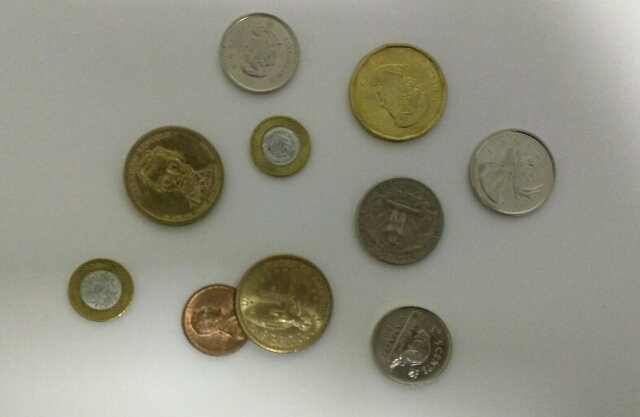

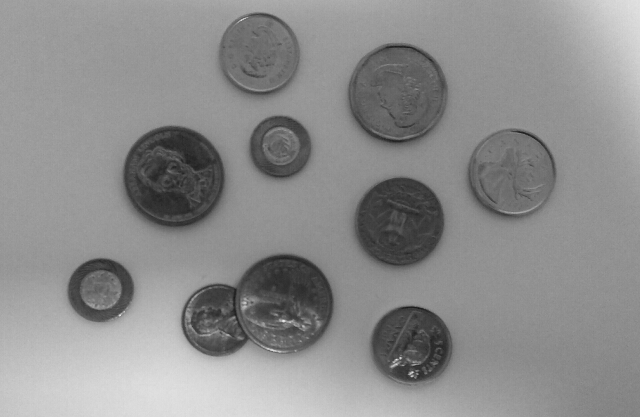

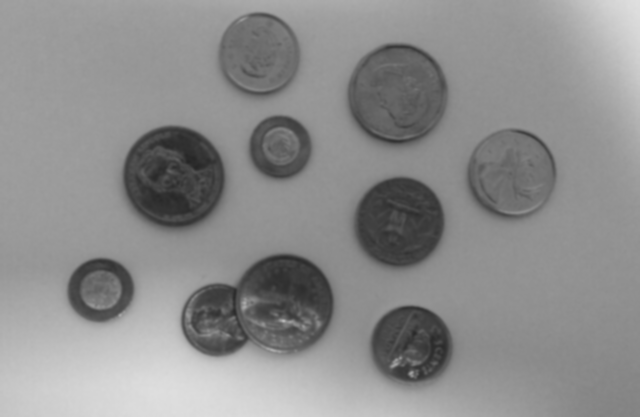

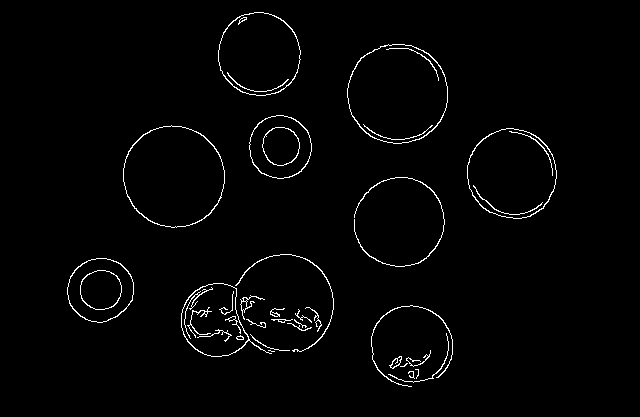

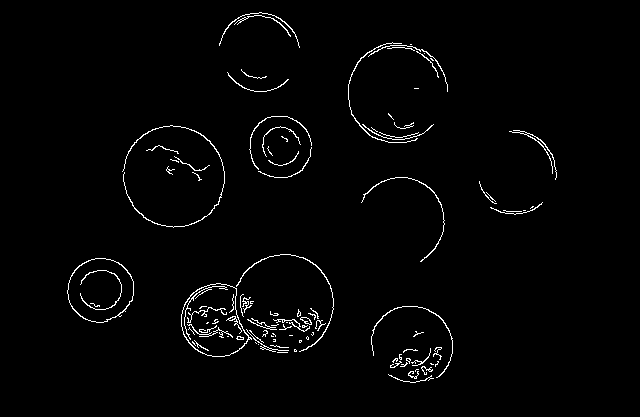

Detecting Hough Circles Started!
217 320 37 0.67
100 290 33 0.62
100 289 21 0.62
218 320 37 0.6
280 146 32 0.59
284 303 50 0.59
174 176 51 0.58
217 322 35 0.57
99 290 32 0.55
173 176 51 0.54
217 321 36 0.54
218 322 35 0.54
280 147 31 0.53
285 303 50 0.53
397 93 50 0.51
98 290 32 0.51
100 290 21 0.51
174 175 52 0.5
281 301 47 0.5
219 321 36 0.5
218 319 38 0.5
279 147 32 0.49
172 175 50 0.49
217 319 37 0.49
100 288 22 0.49
210 311 26 0.48
211 312 25 0.48
398 92 51 0.47
398 93 51 0.47
99 289 20 0.47
99 290 20 0.47
216 320 36 0.47
218 321 36 0.47
205 309 21 0.47
394 91 47 0.46
398 92 48 0.46
280 147 32 0.46
283 302 49 0.46
282 302 48 0.46
210 310 25 0.46
396 94 49 0.45
175 175 52 0.45
283 304 50 0.45
285 302 51 0.45
209 310 25 0.45
215 320 35 0.45
216 321 36 0.45
208 310 24 0.45
207 310 23 0.45
101 289 21 0.44
218 321 38 0.44
214 317 33 0.44
211 311 26 0.44
219 320 35 0.44
209 311 25 0.44
214 321 34 0.44
399 92 48 0.43
281 146 32 0.43
171 174 49 0.43
172 176 51 0.43
101 290 33 0.43
99 290 

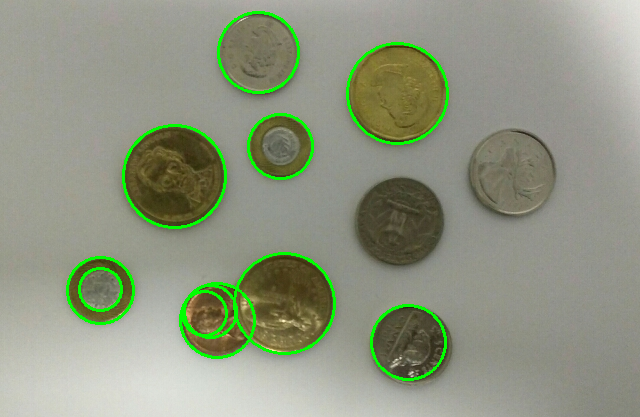

Detecting Hough Circles Complete!


In [6]:
main()